In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
root = '/gdrive/My Drive/Neuron/'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from mlxtend.plotting import plot_decision_regions
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import initializers
from tensorflow import constant_initializer
from tensorflow.keras.utils import plot_model

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
def creating_model(X_train, Y_train):#Problem 1 Model
  
  model = Sequential()
 
  model.add(Dense(1, activation='sigmoid', input_dim=X_train.shape[1], name = "Output_Layer", kernel_initializer=initializers.RandomNormal(seed=0)))
  model.summary()

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics =['accuracy'])
  model.fit(X_train, Y_train, epochs=2000, verbose=False)

  print("\n")
  print("Accuracy of Train Set")
  model.evaluate(X_train, Y_train)
  print("\n")
  
  plot_decision_regions(X=X_train, y=Y_train.to_numpy().ravel(), clf=model, legend=2)
  plt.xlabel("weight", size=15)
  plt.ylabel("speed", size=15)
  plt.title('Plot Decision Region Boundary', size=15)
  plt.show()

  print("\n")
  print("\n")
  print("Weights of Model")
  print(model.get_layer("Output_Layer").get_weights()[0])
  return model

In [ ]:
def sigmoid(x): 
    return 1 / (1 + np.exp(-x))

# RBF Library(From Github)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import RandomUniform, Initializer, Constant
import numpy as np


class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X
        super().__init__()

    def __call__(self, shape, dtype=None):
        assert shape[1:] == self.X.shape[1:]  # check dimension

        # np.random.randint returns ints from [low, high) !
        idx = np.random.randint(self.X.shape[0], size=shape[0])

        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):

        self.output_dim = output_dim

        # betas is either initializer object or float
        if isinstance(betas, Initializer):
            self.betas_initializer = betas
        else:
            self.betas_initializer = Constant(value=betas)

        self.initializer = initializer if initializer else RandomUniform(
            0.0, 1.0)

        super().__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=self.betas_initializer,
                                     # initializer='ones',
                                     trainable=True)

        super().build(input_shape)

    def call(self, x):

        C = tf.expand_dims(self.centers, -1)  # inserts a dimension of 1
        H = tf.transpose(C-tf.transpose(x))  # matrix of differences
        return tf.exp(-self.betas * tf.math.reduce_sum(H**2, axis=1))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

# Problem 1

## Case 1

In [ ]:
train_data = pd.read_csv(root+"Neuron_data.csv", delimiter=";")
train_data

,type,weight,speed,target
0,Mirage IIIB,26455,1460,S
1,Mirage F.1E,33510,1450,S
2,Mirage 2000,36375,1550,S
3,F16,37500,1350,S
4,F14,72000,1564,S
5,B52H,505000,595,B
6,B1b,477000,825,B
7,KC10,590000,600,B


In [ ]:
X_train = train_data[["weight", "speed"]]
Y_train = train_data["target"]
Y_train = pd.get_dummies(Y_train, columns=['target'], drop_first=True)

sc = MinMaxScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)

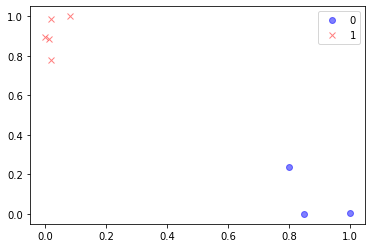

In [ ]:
plt.plot(X_train[Y_train.to_numpy().ravel()==0, 0], X_train[Y_train.to_numpy().ravel()==0, 1], 'ob', alpha=0.5)
plt.plot(X_train[Y_train.to_numpy().ravel()==1, 0], X_train[Y_train.to_numpy().ravel()==1, 1], 'xr', alpha=0.5)
plt.legend(['0', '1'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output_Layer (Dense)        (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


Accuracy of Train Set
1/1 [==============================] - 0s 142ms/step - loss: 0.2115 - accuracy: 1.0000




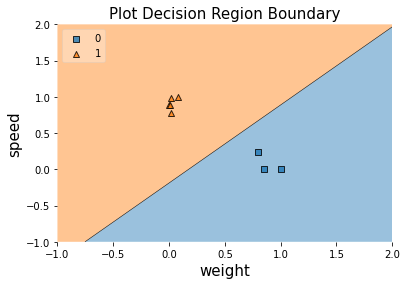





Weights of Model
[[-1.7552438]
 [ 1.6294415]]


In [ ]:
model = creating_model(X_train, Y_train)

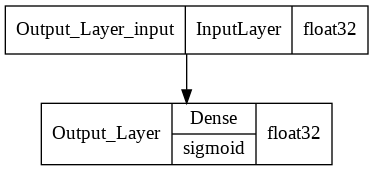

In [ ]:
plot_model(
    model,
    to_file=root + "Problem_1_1.png",
    show_shapes=False,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

## Case 2

In [ ]:
test_dict = {"weight":[565035 ,68000, 50064, 406966],"speed":[559, 1653, 1190, 516]}

In [ ]:
X_test_df = pd.DataFrame(test_dict)
X_test_df

,weight,speed
0,565035,559
1,68000,1653
2,50064,1190
3,406966,516


In [ ]:
X_test = sc.transform(X_test_df)
X_test

array([[ 0.95570008, -0.0371517 ],
       [ 0.07372082,  1.09184727],
       [ 0.04189373,  0.61403509],
       [ 0.67520961, -0.08152735]])

In [ ]:
Y_pred=model.predict(X_test)
Y_pred

array([[0.19296446],
       [0.8761933 ],
       [0.77454615],
       [0.26681548]], dtype=float32)

In [ ]:
Y_pred = (Y_pred > 0.5).astype(int)

In [ ]:
X_test_df["prediction"] = Y_pred
X_test_df

,weight,speed,prediction
0,565035,559,0
1,68000,1653,1
2,50064,1190,1
3,406966,516,0


## Case 3

In [ ]:
new_data_dict = {"type":["Harrier GR-3", "DC9"],"weight":[26000, 149471],"speed":[737, 518], "target":["S","B"]}

In [ ]:
new_data = pd.DataFrame(new_data_dict)

In [ ]:
train_data_new = pd.concat([train_data, new_data], axis=0, ignore_index=True)
train_data_new

,type,weight,speed,target
0,Mirage IIIB,26455,1460,S
1,Mirage F.1E,33510,1450,S
2,Mirage 2000,36375,1550,S
3,F16,37500,1350,S
4,F14,72000,1564,S
5,B52H,505000,595,B
6,B1b,477000,825,B
7,KC10,590000,600,B
8,Harrier GR-3,26000,737,S
9,DC9,149471,518,B


In [ ]:
X_train = train_data_new[["weight", "speed"]]
Y_train = train_data_new["target"]
Y_train = pd.get_dummies(Y_train, columns=['target'], drop_first=True)

sc = MinMaxScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)

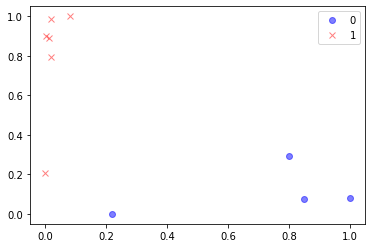

In [ ]:
plt.plot(X_train[Y_train.to_numpy().ravel()==0, 0], X_train[Y_train.to_numpy().ravel()==0, 1], 'ob', alpha=0.5)
plt.plot(X_train[Y_train.to_numpy().ravel()==1, 0], X_train[Y_train.to_numpy().ravel()==1, 1], 'xr', alpha=0.5)
plt.legend(['0', '1'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output_Layer (Dense)        (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


Accuracy of Train Set
1/1 [==============================] - 0s 113ms/step - loss: 0.2967 - accuracy: 1.0000




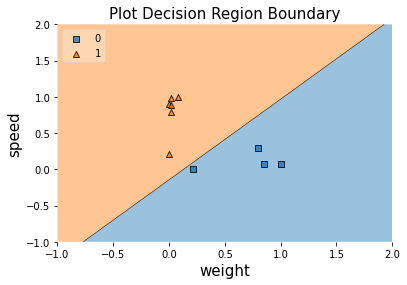





Weights of Model
[[-1.6844884]
 [ 1.5140189]]


In [ ]:
model = creating_model(X_train, Y_train)

## Case 4

In [ ]:
wrong_data_dict = {"type":["-","-"], "weight":[150000, 250000],"speed":[900, 800], "target": ["B", "S"]}

In [ ]:
wrong_data = pd.DataFrame(wrong_data_dict)
wrong_data

,type,weight,speed,target
0,-,150000,900,B
1,-,250000,800,S


In [ ]:
train_wrong_data = pd.concat([train_data_new, wrong_data], axis=0, ignore_index=True)
train_wrong_data

,type,weight,speed,target
0,Mirage IIIB,26455,1460,S
1,Mirage F.1E,33510,1450,S
2,Mirage 2000,36375,1550,S
3,F16,37500,1350,S
4,F14,72000,1564,S
5,B52H,505000,595,B
6,B1b,477000,825,B
7,KC10,590000,600,B
8,Harrier GR-3,26000,737,S
9,DC9,149471,518,B


In [ ]:
X_train = train_wrong_data[["weight", "speed"]]
Y_train = train_wrong_data["target"]
Y_train = pd.get_dummies(Y_train, columns=['target'], drop_first=True)

sc = MinMaxScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)

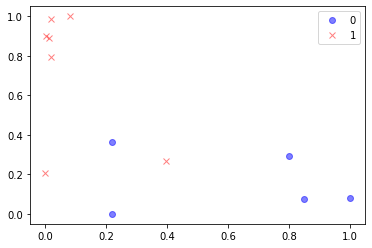

In [ ]:
plt.plot(X_train[Y_train.to_numpy().ravel()==0, 0], X_train[Y_train.to_numpy().ravel()==0, 1], 'ob', alpha=0.5)
plt.plot(X_train[Y_train.to_numpy().ravel()==1, 0], X_train[Y_train.to_numpy().ravel()==1, 1], 'xr', alpha=0.5)
plt.legend(['0', '1'])

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output_Layer (Dense)        (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


Accuracy of Train Set
1/1 [==============================] - 0s 121ms/step - loss: 0.3735 - accuracy: 0.8333




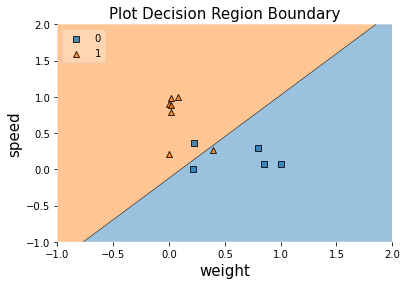





Weights of Model
[[-1.7976289]
 [ 1.5702418]]


In [ ]:
creating_model(X_train, Y_train)

# Problem 2

In [ ]:
train_data_dict = {"first_proof":[1000, 100, 980, 95],"second_proof":[975, 990, 110, 170],"target":["self-defense", "intentional", "intentional", "self-defense"]}

In [ ]:
train_data = pd.DataFrame(train_data_dict)

In [ ]:
X_train = train_data[["first_proof", "second_proof"]]
Y_train = train_data[["target"]]

Y_train['target'].loc[Y_train['target'] == 'self-defense'] = 0
Y_train['target'].loc[Y_train['target'] == 'intentional'] = 1
Y_train = Y_train.astype("uint8")
Y_train = Y_train.values

sc = MinMaxScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)

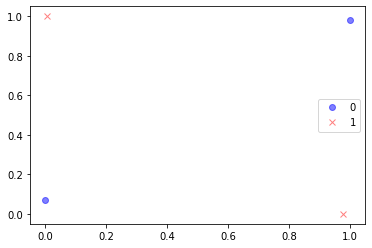

In [ ]:
plt.plot(X_train[Y_train.ravel()==0, 0], X_train[Y_train.ravel()==0, 1], 'ob', alpha=0.5)
plt.plot(X_train[Y_train.ravel()==1, 0], X_train[Y_train.ravel()==1, 1], 'xr', alpha=0.5)
plt.legend(['0', '1'])

## 2-A

In [ ]:
input_dim = X_train.shape[1]
hidden_dim = 2
output_dim = Y_train.shape[1]

np.random.seed(0)

W1 = np.random.random((X_train.shape[1], hidden_dim))
W2 = np.random.random((hidden_dim, Y_train.shape[1]))

In [ ]:
print(input_dim)
print(output_dim)

2
1


In [ ]:
print(W1)
print(W2)

[[0.5488135  0.71518937]
 [0.60276338 0.54488318]]
[[0.4236548 ]
 [0.64589411]]


### a)

In [ ]:
layer_0 = pd.DataFrame(X_train)

layer_0_unit_1 = layer_0[0]
layer_0_unit_2 = layer_0[1]

layer_1_unit_1 = np.tanh(layer_0_unit_1 * W1[0,0] + layer_0_unit_2 * W1[1,0])
layer_1_unit_2 = np.tanh(layer_0_unit_1 * W1[0,1] + layer_0_unit_2 * W1[1,1])

layer_2 = sigmoid(layer_1_unit_1 * W2[0] + layer_1_unit_2 * W2[1])
layer_2_pred = layer_2.round()
layer_2_pred

0    1.0
1    1.0
2    1.0
3    1.0
dtype: float64

### b)

In [ ]:
model2 = Sequential()

model2.add(Dense(hidden_dim, activation='tanh', input_dim=input_dim, name = "Hidden_Layer_1", kernel_initializer=constant_initializer(W1)))

model2.add(Dense(output_dim, activation='sigmoid', name = "Output_Layer", kernel_initializer=constant_initializer(W2)))
model2.summary()


sgd = SGD(learning_rate=0.5, momentum=0.9)
model2.compile(loss='mean_squared_error', optimizer=sgd, metrics=['binary_accuracy'])

model2.fit(X_train, Y_train, epochs=100, verbose=False)

print(model2.predict(X_train).round())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, 2)                 6         
                                                                 
 Output_Layer (Dense)        (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
[[1.]
 [1.]
 [1.]
 [0.]]


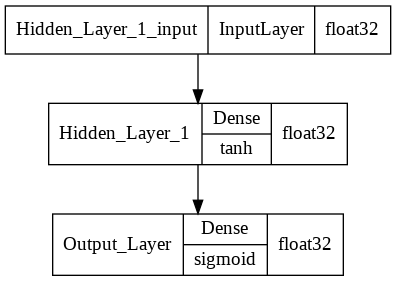

In [ ]:
plot_model(
    model2,
    to_file=root + "Problem_2_2.png",
    show_shapes=False,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

### c)

In [ ]:
model2 = Sequential()

model2.add(Dense(hidden_dim, activation='tanh', input_dim=input_dim, name = "Hidden_Layer_1", kernel_initializer=constant_initializer(W1)))

model2.add(Dense(output_dim, activation='sigmoid', name = "Output_Layer", kernel_initializer=constant_initializer(W2)))
model2.summary()


sgd = SGD(learning_rate=0.5, momentum=0.9)
model2.compile(loss='mean_squared_error', optimizer=sgd, metrics=['binary_accuracy'])

model2.fit(X_train, Y_train, epochs=500)

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, 2)                 6         
                                                                 
 Output_Layer (Dense)        (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/1 [==============================] - 0s 368ms/step - loss: 0.2558 - binary_accuracy: 0.5000
Epoch 2/500
1/1 [==============================] - 0s 6ms/step - loss: 0.2539 - binary_accuracy: 0.5000
Epoch 3/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2507 - binary_accuracy: 0.7500
Epoch 4/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2474 - binary_accuracy: 0.7500
Epoch 5/500
1/1 [====================

In [ ]:
print(model2.predict(X_train).round())

[[0.]
 [1.]
 [1.]
 [0.]]


In [ ]:
model2.evaluate(X_train, Y_train)

1/1 [==============================] - 0s 108ms/step - loss: 4.4411e-04 - binary_accuracy: 1.0000


[0.0004441149940248579, 1.0]

In [ ]:
layer_1_weights, layer_1_biases = model2.layers[0].get_weights()
layer_1_weights

array([[2.4146323, 4.1648755],
       [2.3259852, 3.9388304]], dtype=float32)

In [ ]:
layer_2_weights, layer_2_biases = model2.layers[1].get_weights()
layer_2_weights

array([[-4.785246 ],
       [ 4.5716176]], dtype=float32)

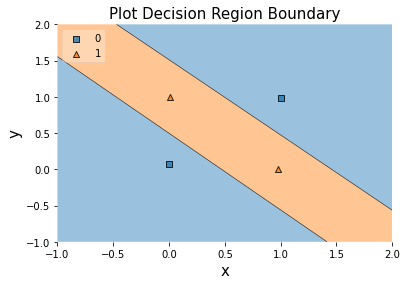

In [ ]:
plot_decision_regions(X=X_train, y=Y_train.ravel(), clf=model2, legend=2)
plt.xlabel("x", size=15)
plt.ylabel("y", size=15)
plt.title('Plot Decision Region Boundary', size=15)
plt.show()

### d)

#### What are the results when the learning rate, momentum, and initial weights change?


In [ ]:
learning_rate_dizi = [0.1, 0.5, 1, 2]
momentum_dizi = [0.1, 0.5, 0.9, 1]
accuracy_dizi=[]

In [ ]:
for i in learning_rate_dizi:

  for j in momentum_dizi:

    model_farkli = Sequential()

    model_farkli.add(Dense(hidden_dim, activation='tanh', input_dim=input_dim, name = "Hidden_Layer_1", kernel_initializer=constant_initializer(W1)))

    model_farkli.add(Dense(output_dim, activation='sigmoid', name = "Output_Layer", kernel_initializer=constant_initializer(W2)))

    sgd = SGD(learning_rate=i, momentum=j)
    model_farkli.compile(loss='mean_squared_error', optimizer=sgd, metrics=['binary_accuracy'])

    model_farkli.fit(X_train, Y_train, verbose=False, epochs=500)

    accuracy_dizi.append((i, j, model_farkli.evaluate(X_train, Y_train)[0], model_farkli.evaluate(X_train, Y_train)[1]))

1/1 [==============================] - 0s 22ms/step - loss: 0.1668 - binary_accuracy: 0.7500


In [ ]:
accuracy_df = pd.DataFrame(accuracy_dizi, columns=["learning_rate", "momentum", "loss", "accuracy"])
accuracy_df

,learning_rate,momentum,loss,accuracy
0,0.1,0.1,0.217484,0.75
1,0.1,0.5,0.194560,0.75
2,0.1,0.9,0.011648,1.00
3,0.1,1.0,0.173414,0.75
4,0.5,0.1,0.111410,0.75
5,0.5,0.5,0.006211,1.00
6,0.5,0.9,0.000444,1.00
7,0.5,1.0,0.176324,0.75
8,1.0,0.1,0.004480,1.00
9,1.0,0.5,0.001492,1.00


#### When using more hidden unit

In [ ]:
input_dim = X_train.shape[1]
hidden_dim_deneme = [2,4,8,16]
output_dim = Y_train.shape[1]

np.random.seed(0)

accuracy_dizi_2 = []

In [ ]:
for i in hidden_dim_deneme:

  W1_deneme = np.random.random((X_train.shape[1], i))
  W2_deneme = np.random.random((i, Y_train.shape[1]))

  model_farkli_2 = Sequential()

  model_farkli_2.add(Dense(i, activation='tanh', input_dim=input_dim, name = "Hidden_Layer_1", kernel_initializer=constant_initializer(W1_deneme)))

  model_farkli_2.add(Dense(output_dim, activation='sigmoid', name = "Output_Layer", kernel_initializer=constant_initializer(W2_deneme)))


  sgd = SGD(learning_rate=0.5, momentum=0.9)
  model_farkli_2.compile(loss='mean_squared_error', optimizer=sgd, metrics=['binary_accuracy'])

  model_farkli_2.fit(X_train, Y_train, verbose=False, epochs=500)

  accuracy_dizi_2.append((i, model_farkli_2.evaluate(X_train, Y_train)[0], model_farkli_2.evaluate(X_train, Y_train)[1]))

1/1 [==============================] - 0s 19ms/step - loss: 2.1383e-04 - binary_accuracy: 1.0000


In [ ]:
accuracy_dizi_2_df = pd.DataFrame(accuracy_dizi_2, columns=["num_of_neuron", "loss", "accuracy"])
accuracy_dizi_2_df

,num_of_neuron,loss,accuracy
0,2,0.000444,1.0
1,4,0.000279,1.0
2,8,0.000183,1.0
3,16,0.000214,1.0


## 2-B

In [ ]:
input_dim = X_train.shape[1]
hidden_dim = 2
output_dim = Y_train.shape[1]

np.random.seed(0)

W2 = np.random.random((hidden_dim, Y_train.shape[1]))

In [ ]:
model_rbf = Sequential()
model_rbf.add(RBFLayer(2,
                      initializer=InitCentersRandom(X_train),
                      betas=5.0,
                      input_shape=(input_dim,)))
model_rbf.add(Dense(output_dim, name = "Output_Layer", kernel_initializer=constant_initializer(W2)))

model_rbf.summary()

model_rbf.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['binary_accuracy'])

model_rbf.fit(X_train, Y_train, epochs=1500, verbose=True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer_4 (RBFLayer)      (None, 2)                 6         
                                                                 
 Output_Layer (Dense)        (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
1/1 [==============================] - 1s 668ms/step - loss: 0.4263 - binary_accuracy: 0.5000
Epoch 2/1500
1/1 [==============================] - 0s 7ms/step - loss: 0.4232 - binary_accuracy: 0.5000
Epoch 3/1500
1/1 [==============================] - 0s 6ms/step - loss: 0.4208 - binary_accuracy: 0.5000
Epoch 4/1500
1/1 [==============================] - 0s 10ms/step - loss: 0.4189 - binary_accuracy: 0.5000
Epoch 5/1500
1/1 [===============

In [ ]:
print(model_rbf.predict(X_train).round())

[[-0.]
 [ 1.]
 [ 1.]
 [-0.]]


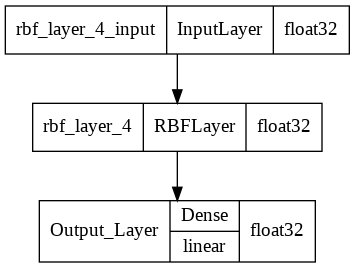

In [ ]:
plot_model(
    model_rbf,
    to_file=root + "Problem_2_2.png",
    show_shapes=False,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

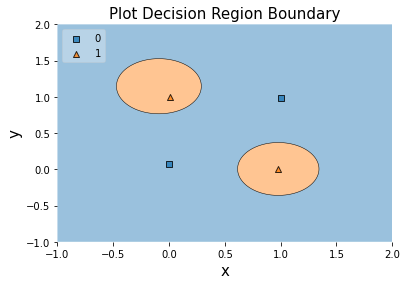

In [ ]:
plot_decision_regions(X=X_train, y=Y_train.ravel(), clf=model_rbf, legend=2)
plt.xlabel("x", size=15)
plt.ylabel("y", size=15)
plt.title('Plot Decision Region Boundary', size=15)
plt.show()